<a href="https://colab.research.google.com/github/KL193/DR_Research/blob/main/DR_Metadata_Synthesis_and_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install All dependecies

In [1]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q efficientnet-pytorch==0.7.1
!pip install -q grad-cam
!pip install -q xgboost shap scikit-learn pandas numpy matplotlib seaborn torchsummary


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Importing Libraries and basic setup

In [17]:
import os
import random
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)

from efficientnet_pytorch import EfficientNet
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import xgboost as xgb

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data set

---



In [4]:
import pandas as pd

path = '/content/drive/My Drive/DR_Project/dataset/messidor2/messidor_data.csv'
df = pd.read_csv(path)
df.head()


,id_code,diagnosis,adjudicated_dme,adjudicated_gradable
0,20051020_43808_0100_PP.png,0,0,1
1,20051020_43832_0100_PP.png,1,0,1
2,20051020_43882_0100_PP.png,1,0,1
3,20051020_43906_0100_PP.png,2,1,1
4,20051020_44261_0100_PP.png,0,0,1


In [5]:
import os

image_dir = '/content/drive/My Drive/DR_Project/dataset/messidor2/preprocess'
print("Total images:", len(os.listdir(image_dir)))
print("Example images:", os.listdir(image_dir)[:5])


Total images: 1744
Example images: ['20060411_61702_0200_PP.png', '20060411_61901_0200_PP.png', '20060411_62036_0200_PP.png', '20060411_62298_0200_PP.png', '20060412_52038_0200_PP.png']


# Metadata Synthetic

In [6]:

import numpy as np
import random


def generate_metadata(dr_grade):
    # Base ranges (realistic values based on DR severity)
    if dr_grade == 0:
        age = np.random.normal(45, 10)
        hba1c = np.random.normal(6.0, 0.5)
        duration = np.random.normal(3, 2)
        sbp = np.random.normal(120, 10)
    elif dr_grade == 1:
        age = np.random.normal(50, 10)
        hba1c = np.random.normal(7.0, 0.6)
        duration = np.random.normal(6, 3)
        sbp = np.random.normal(130, 12)
    elif dr_grade == 2:
        age = np.random.normal(55, 10)
        hba1c = np.random.normal(7.8, 0.7)
        duration = np.random.normal(10, 4)
        sbp = np.random.normal(140, 12)
    elif dr_grade == 3:
        age = np.random.normal(60, 8)
        hba1c = np.random.normal(8.6, 0.8)
        duration = np.random.normal(14, 5)
        sbp = np.random.normal(150, 15)
    else:  # Grade 4
        age = np.random.normal(65, 8)
        hba1c = np.random.normal(9.4, 0.9)
        duration = np.random.normal(18, 5)
        sbp = np.random.normal(160, 15)

    return round(age,1), round(hba1c,1), round(duration,1), round(sbp,1)


metadata = df['diagnosis'].apply(lambda x: generate_metadata(x))
metadata_df = pd.DataFrame(metadata.tolist(), columns=['age','hba1c','duration','sbp'])
df = pd.concat([df, metadata_df], axis=1)

print("Synthetic metadata added successfully!")
df[['id_code', 'diagnosis', 'age', 'hba1c', 'duration', 'sbp']].head(10)

Synthetic metadata added successfully!


,id_code,diagnosis,age,hba1c,duration,sbp
0,20051020_43808_0100_PP.png,0,50.0,5.9,4.3,135.2
1,20051020_43832_0100_PP.png,1,47.7,6.9,10.7,139.2
2,20051020_43882_0100_PP.png,1,45.3,7.3,4.6,124.4
3,20051020_43906_0100_PP.png,2,57.4,6.5,3.1,133.3
4,20051020_44261_0100_PP.png,0,34.9,6.2,1.2,105.9
5,20051020_44284_0100_PP.png,0,59.7,5.9,3.1,105.8
6,20051020_44338_0100_PP.png,0,39.6,6.1,0.7,123.8
7,20051020_44349_0100_PP.png,2,49.0,7.6,7.6,162.2
8,20051020_44400_0100_PP.png,0,44.9,5.5,4.6,107.8
9,20051020_44431_0100_PP.png,0,47.1,5.0,0.3,122.0


In [7]:
import os


os.makedirs('/content/drive/My Drive/DR_Project/data', exist_ok=True)

# Saving  the synthetic data csv
df.to_csv('/content/drive/My Drive/DR_Project/data/full_dataset_with_metadata.csv', index=False)



# Load Combined Dataset + Verify Images

Image 0: 20051020_43808_0100_PP.png → Exists? True


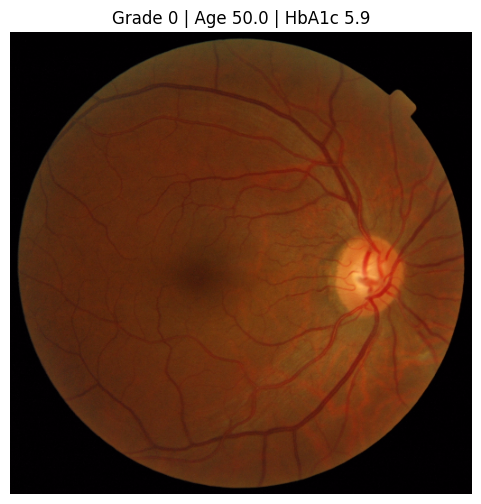

Image 1: 20051020_43832_0100_PP.png → Exists? True


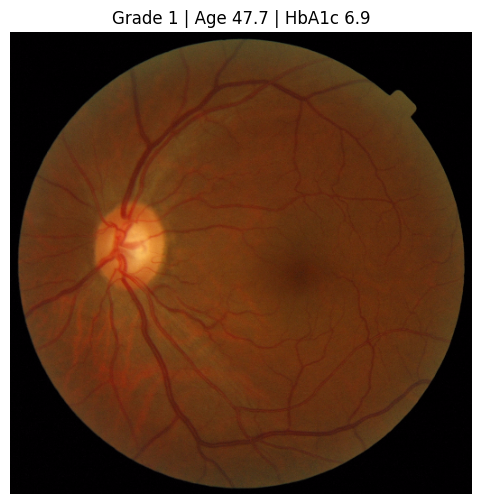

Image 2: 20051020_43882_0100_PP.png → Exists? True


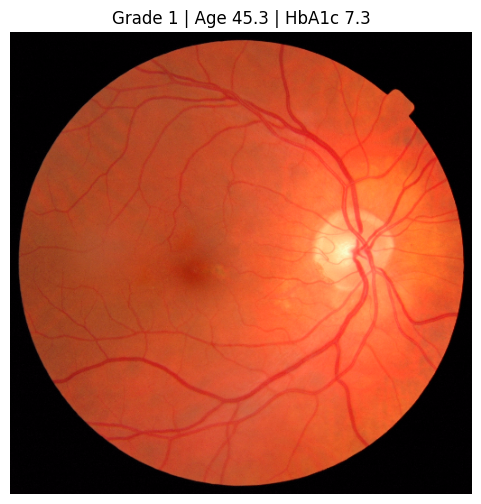

In [8]:

import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt


csv_path = '/content/drive/My Drive/DR_Project/data/full_dataset_with_metadata.csv'
df = pd.read_csv(csv_path)


df['filename'] = df['id_code']
image_dir = '/content/drive/My Drive/DR_Project/dataset/messidor2/preprocess'

# Test first 3 images
for i in range(3):
    path = os.path.join(image_dir, df.iloc[i]['filename'])
    print(f"Image {i}: {df.iloc[i]['filename']} → Exists? {os.path.exists(path)}")

    if os.path.exists(path):
        img = Image.open(path)
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title(f"Grade {df.iloc[i]['diagnosis']} | Age {df.iloc[i]['age']} | HbA1c {df.iloc[i]['hba1c']}")
        plt.axis('off')
        plt.show()
    else:
        print("Still not found — check folder path!")

In [9]:
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Load data
csv_path = '/content/drive/My Drive/DR_Project/data/full_dataset_with_metadata.csv'
df = pd.read_csv(csv_path)

if 'filename' not in df.columns:
    df['filename'] = df['id_code']

print(f"   Loaded {len(df)} images")
print(f"   Columns: {df.columns.tolist()}")

# Check class distribution
print(f"\n Class Distribution:")
class_counts = df['diagnosis'].value_counts().sort_index()
for grade, count in class_counts.items():
    print(f"   Grade {grade}: {count} ({count/len(df)*100:.1f}%)")


   Loaded 1744 images
   Columns: ['id_code', 'diagnosis', 'adjudicated_dme', 'adjudicated_gradable', 'age', 'hba1c', 'duration', 'sbp', 'filename']

 Class Distribution:
   Grade 0: 1017 (58.3%)
   Grade 1: 270 (15.5%)
   Grade 2: 347 (19.9%)
   Grade 3: 75 (4.3%)
   Grade 4: 35 (2.0%)


# Splitting Data

In [10]:
from sklearn.model_selection import train_test_split

# Set a random seed for reproducibility
SEED = 42

# Split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df['diagnosis'],
    random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['diagnosis'],
    random_state=SEED
)

print(f"   Data split complete:")
print(f"   Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"   Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"   Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# Verify stratification
print(f"\n Stratification Check:")
print("Grade | Train | Val | Test")

for grade in sorted(df['diagnosis'].unique()):
    train_count = (train_df['diagnosis'] == grade).sum()
    val_count = (val_df['diagnosis'] == grade).sum()
    test_count = (test_df['diagnosis'] == grade).sum()
    print(f"  {grade}   |  {train_count:3d}  | {val_count:2d}  | {test_count:2d}")


   Data split complete:
   Train: 1220 (70.0%)
   Val:   262 (15.0%)
   Test:  262 (15.0%)

 Stratification Check:
Grade | Train | Val | Test
  0   |  711  | 153  | 153
  1   |  189  | 40  | 41
  2   |  243  | 52  | 52
  3   |   52  | 12  | 11
  4   |   25  |  5  |  5


# Normalize Meta Data

In [11]:
metadata_cols = ['age', 'hba1c', 'duration', 'sbp']

# Create scaler
scaler = StandardScaler()


print(f"\n Before Normalization (Train set):")
print(train_df[metadata_cols].describe())

# Fit on training data ONLY
train_df[metadata_cols] = scaler.fit_transform(train_df[metadata_cols])

# Transform val and test using training statistics
val_df[metadata_cols] = scaler.transform(val_df[metadata_cols])
test_df[metadata_cols] = scaler.transform(test_df[metadata_cols])

print(f"\n Normalization complete!")
print(f"\n After Normalization (Train set):")
print(train_df[metadata_cols].describe())

print(f"\n Scaler Parameters (from training data):")
print(f"   Mean: {scaler.mean_}")
print(f"   Std:  {scaler.scale_}")

# Save scaler
models_dir = "/content/drive/My Drive/DR_Project/models"
os.makedirs(models_dir, exist_ok=True)

joblib.dump(scaler, f"{models_dir}/scaler.pkl")
print(f"\n Scaler saved to: {models_dir}/scaler.pkl")




 Before Normalization (Train set):
               age        hba1c     duration          sbp
count  1220.000000  1220.000000  1220.000000  1220.000000
mean     49.271066     6.685984     5.503852   127.481148
std      11.143354     1.086893     4.815527    15.394026
min      14.800000     4.400000    -3.700000    90.900000
25%      41.200000     5.900000     2.300000   116.900000
50%      49.250000     6.400000     4.200000   125.600000
75%      57.000000     7.400000     7.700000   137.000000
max      86.600000    10.800000    29.500000   191.000000

 Normalization complete!

 After Normalization (Train set):
                age         hba1c      duration           sbp
count  1.220000e+03  1.220000e+03  1.220000e+03  1.220000e+03
mean  -6.406533e-17  3.421671e-17 -1.004661e-16 -4.368091e-16
std    1.000410e+00  1.000410e+00  1.000410e+00  1.000410e+00
min   -3.094688e+00 -2.104089e+00 -1.912071e+00 -2.377295e+00
25%   -7.245911e-01 -7.234434e-01 -6.655900e-01 -6.876360e-01
50%   -1.

# Save Splitted Data

In [12]:
os.makedirs('/content/drive/My Drive/DR_Project/data/splits', exist_ok=True)

train_df.to_csv('/content/drive/My Drive/DR_Project/data/splits/train.csv', index=False)
val_df.to_csv('/content/drive/My Drive/DR_Project/data/splits/val.csv', index=False)
test_df.to_csv('/content/drive/My Drive/DR_Project/data/splits/test.csv', index=False)


print("   - train.csv (normalized metadata)")
print("   - val.csv (normalized metadata)")
print("   - test.csv (normalized metadata)")



   - train.csv (normalized metadata)
   - val.csv (normalized metadata)
   - test.csv (normalized metadata)


# Verify Image paths

In [13]:


image_dir = '/content/drive/My Drive/DR_Project/dataset/messidor2/preprocess'

# Check if all images exist
missing_count = 0
for idx, row in train_df.head(10).iterrows():
    img_path = os.path.join(image_dir, row['filename'])
    exists = os.path.exists(img_path)
    if not exists:
        missing_count += 1
        print(f" Missing: {img_path}")
    else:
        print(f" Found: {row['filename']}")

if missing_count == 0:
    print("\n All sample images found!")
else:
    print(f"\n Warning: {missing_count} images not found!")
    print("Check your image_dir path and filename column!")

 Found: 20060407_41831_0200_PP.png
 Found: IM003482.JPG
 Found: IM004132.JPG
 Found: IM004192.JPG
 Found: IM003147.JPG
 Found: 20051021_58316_0100_PP.png
 Found: 20060411_59812_0200_PP.png
 Found: IM003330.JPG
 Found: IM000726.JPG
 Found: 20051130_54030_0400_PP.png

 All sample images found!


In [14]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class DRMultiModalDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, str(row['filename']))
        # Safe image open
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            # if missing or corrupted, return a black image
            img = Image.new('RGB', (224,224), (0,0,0))
        if self.transform:
            img = self.transform(img)
        meta = torch.tensor(row[metadata_cols].values.astype(np.float32))
        label = torch.tensor(int(row['diagnosis']), dtype=torch.long)
        return img, meta, label

batch_size = 32
num_workers = 2  # reduce to 0 if you hit issues on Colab
train_loader = DataLoader(DRMultiModalDataset(train_df, image_dir, train_transform),
                          batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(DRMultiModalDataset(val_df, image_dir, val_test_transform),
                        batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(DRMultiModalDataset(test_df, image_dir, val_test_transform),
                         batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Dataloaders ready. Batches:", len(train_loader), len(val_loader), len(test_loader))


Dataloaders ready. Batches: 39 9 9


# Model Architecture: Custom CNN, Metadata Network, and Fusion Model

In [16]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
import shap
from torchsummary import summary

class FusionModel(nn.Module):
    def __init__(self, num_classes=5, backbone_pretrained=True):
        super().__init__()
        backbone = resnet50(pretrained=backbone_pretrained)
        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.meta_net = nn.Sequential(
            nn.Linear(4, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 64), nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 64, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, img, meta):
        img_feat = self.backbone(img)
        meta_feat = self.meta_net(meta)
        fused = torch.cat([img_feat, meta_feat], dim=1)
        return self.classifier(fused)

class EfficientNetB0Model(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        in_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

class EfficientNetB3Model(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b3')
        in_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)


# Training and Evaluation Functions

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device, model_type='image'):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for batch_data in loader:
        if model_type == 'metadata':
            _, meta, labels = batch_data
            meta, labels = meta.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(meta)
        elif model_type == 'fusion':
            img, meta, labels = batch_data
            img, meta, labels = img.to(device), meta.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(img, meta)
        else:  # image-only models
            img, _, labels = batch_data
            img, labels = img.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(img)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def evaluate_model(model, loader, criterion, device, model_type='image'):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch_data in loader:
            if model_type == 'metadata':
                _, meta, labels = batch_data
                meta, labels = meta.to(device), labels.to(device)
                outputs = model(meta)
            elif model_type == 'fusion':
                img, meta, labels = batch_data
                img, meta, labels = img.to(device), meta.to(device), labels.to(device)
                outputs = model(img, meta)
            else:
                img, _, labels = batch_data
                img, labels = img.to(device), labels.to(device)
                outputs = model(img)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_probs)


#  TRAIN BASE MODELS (LEVEL-0 LEARNERS)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import os
import copy

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0
        return self.early_stop

def train_epoch(model, loader, criterion, optimizer, device, model_type='image'):
    """Train model for one epoch with proper error handling"""
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    try:
        for batch_idx, batch_data in enumerate(loader):
            try:
                if model_type == 'metadata':
                    _, meta, labels = batch_data
                    meta, labels = meta.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(meta)
                elif model_type == 'fusion':
                    img, meta, labels = batch_data
                    img, meta, labels = img.to(device), meta.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(img, meta)
                else:  # image-only models
                    img, _, labels = batch_data
                    img, labels = img.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(img)

                loss = criterion(outputs, labels)

                # Check for NaN loss
                if torch.isnan(loss):
                    print(f"Warning: NaN loss detected at batch {batch_idx}, skipping...")
                    continue

                loss.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

                running_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue

        if len(all_labels) == 0:
            return 0.0, 0.0

        epoch_loss = running_loss / len(loader)
        epoch_acc = accuracy_score(all_labels, all_preds)
        return epoch_loss, epoch_acc

    except Exception as e:
        print(f"Critical error in training epoch: {e}")
        return 0.0, 0.0

def evaluate_model(model, loader, criterion, device, model_type='image'):
    """Evaluate model with proper error handling"""
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        try:
            for batch_data in loader:
                if model_type == 'metadata':
                    _, meta, labels = batch_data
                    meta, labels = meta.to(device), labels.to(device)
                    outputs = model(meta)
                elif model_type == 'fusion':
                    img, meta, labels = batch_data
                    img, meta, labels = img.to(device), meta.to(device), labels.to(device)
                    outputs = model(img, meta)
                else:
                    img, _, labels = batch_data
                    img, labels = img.to(device), labels.to(device)
                    outputs = model(img)

                loss = criterion(outputs, labels)
                running_loss += loss.item()

                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        except Exception as e:
            print(f"Error during evaluation: {e}")
            return 0.0, 0.0, [], [], []

    if len(all_labels) == 0:
        return 0.0, 0.0, [], [], []

    epoch_loss = running_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

def train_base_models(train_loader, val_loader, device, num_epochs=20, use_early_stopping=True):


    # Ensure models directory exists
    models_dir = "/content/drive/My Drive/DR_Project/models"
    os.makedirs(models_dir, exist_ok=True)

    models_config = {
        'CustomCNN': (CustomCNN(num_classes=5), 'image', 0.001),
        'EfficientNet-B0': (EfficientNetB0Model(num_classes=5), 'image', 0.0001),  # Lower LR for pretrained
        'EfficientNet-B3': (EfficientNetB3Model(num_classes=5), 'image', 0.0001),  # Lower LR for pretrained
        'ResNet50': (FusionModel(num_classes=5, backbone_pretrained=True), 'fusion', 0.0001),  # Lower LR
        'MetaFCNN': (MetaFCNN(num_classes=5), 'metadata', 0.001)
    }

    trained_models = {}
    training_history = {}

    criterion = nn.CrossEntropyLoss()

    for model_idx, (model_name, (model, model_type, learning_rate)) in enumerate(models_config.items()):
        print(f"\n{'='*70}")
        print(f"Training Model {model_idx+1}/{len(models_config)}: {model_name} ({model_type})")
        print(f"{'='*70}")

        # Move model to device
        model = model.to(device)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total Parameters: {total_params:,}")
        print(f"Trainable Parameters: {trainable_params:,}")

        # Setup optimizer with model-specific learning rate
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

        # Setup scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
              optimizer, mode='max', patience=3, factor=0.5
        )

        # Setup early stopping
        early_stopping = EarlyStopping(patience=5, min_delta=0.001) if use_early_stopping else None

        best_val_acc = 0.0
        best_model_state = None
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'learning_rates': []
        }

        print(f"\nStarting training with learning rate: {learning_rate}")
        print("-" * 70)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_epoch(
                model, train_loader, criterion, optimizer, device, model_type
            )

            # Validation phase
            val_loss, val_acc, _, _, _ = evaluate_model(
                model, val_loader, criterion, device, model_type
            )

            # Update scheduler
            scheduler.step(val_acc)

            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']

            # Store history
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['learning_rates'].append(current_lr)

            # Print progress
            print(f"Epoch {epoch+1:2d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
                  f"LR: {current_lr:.6f}")

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                # Save model state (not just reference)
                best_model_state = copy.deepcopy(model.state_dict())
                torch.save(best_model_state, f"{models_dir}/{model_name}_best.pth")
                print(f"  ✓ New best model saved! (Val Acc: {best_val_acc:.4f})")

            # Early stopping check
            if use_early_stopping and early_stopping(val_acc):
                print(f"\n  ⚠ Early stopping triggered at epoch {epoch+1}")
                print(f"  Best validation accuracy: {best_val_acc:.4f}")
                break

        print(f"Training completed for {model_name}")
        print(f"Best Validation Accuracy: {best_val_acc:.4f}")

        # Load best model state before saving
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        # Store trained model
        trained_models[model_name] = (model, model_type, best_val_acc)
        training_history[model_name] = history

        # Clear GPU cache between models
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


    print("ALL MODELS TRAINING COMPLETED!")

    print("\nBest Validation Accuracies:")

    for model_name, (_, _, best_acc) in trained_models.items():
        print(f"  {model_name:20s}: {best_acc:.4f}")

    return trained_models, training_history


def plot_training_history(training_history, save_path="/content/drive/My Drive/DR_Project/"):
    """Plot training curves for all models"""
    import matplotlib.pyplot as plt

    n_models = len(training_history)
    fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 10))

    if n_models == 1:
        axes = axes.reshape(2, 1)

    for idx, (model_name, history) in enumerate(training_history.items()):
        # Loss plot
        axes[0, idx].plot(history['train_loss'], label='Train Loss', linewidth=2)
        axes[0, idx].plot(history['val_loss'], label='Val Loss', linewidth=2)
        axes[0, idx].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
        axes[0, idx].set_xlabel('Epoch')
        axes[0, idx].set_ylabel('Loss')
        axes[0, idx].legend()
        axes[0, idx].grid(True, alpha=0.3)

        # Accuracy plot
        axes[1, idx].plot(history['train_acc'], label='Train Acc', linewidth=2)
        axes[1, idx].plot(history['val_acc'], label='Val Acc', linewidth=2)
        axes[1, idx].set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
        axes[1, idx].set_xlabel('Epoch')
        axes[1, idx].set_ylabel('Accuracy')
        axes[1, idx].legend()
        axes[1, idx].grid(True, alpha=0.3)

        # Mark best validation accuracy
        best_epoch = history['val_acc'].index(max(history['val_acc']))
        axes[1, idx].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5)
        axes[1, idx].text(best_epoch, max(history['val_acc']),
                         f'Best: {max(history["val_acc"]):.3f}',
                         ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(f"{save_path}/training_curves.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Training curves saved to {save_path}/training_curves.png")


trained_models, training_history = train_base_models(
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    use_early_stopping=True
)

# Plot training curves
plot_training_history(training_history)

# Save training history
import pickle
history_path = "/content/drive/My Drive/DR_Project/training_history.pkl"
with open(history_path, 'wb') as f:
    pickle.dump(training_history, f)
print(f"✓ Training history saved to {history_path}")

NameError: name 'train_loader' is not defined